In [1]:
# ! rm -rf extend-ai-ml-assessment/

In [2]:
!pip install segmentation_models_pytorch -q

In [3]:
'''Installing older version as segmentation_models_pytorch is not
compatible with the latest version'''
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html

Looking in links: https://download.pytorch.org/whl/lts/1.8/torch_lts.html


In [4]:
'''downloading everything'''
! git clone https://github.com/jjaskirat/extend-ai-ml-assessment.git -q

fatal: destination path 'extend-ai-ml-assessment' already exists and is not an empty directory.


In [5]:
% cd /content/extend-ai-ml-assessment

/content/extend-ai-ml-assessment


In [6]:
! ls

annotations.csv  data  README.md


In [7]:
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
from pathlib import Path
import json
import cv2
from skimage import io, transform
from skimage.color import gray2rgb, rgb2gray
import os
import seaborn as sns

In [9]:
import segmentation_models_pytorch as smp

In [10]:
import os
import copy
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import torch
from torchvision import models
import torchvision.transforms as transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip, VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor
warnings.filterwarnings("ignore")
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Data Preparation

I used a software called labelme to manually create the mask for each image and then saved the labels

In [11]:
'''Required my first model for data loading'''
df = {"image": [],
      "mask": [],
      "label": []}

for image in os.listdir("data/negative"):
  df['image'].append(f"data/negative/{image}")
  df['mask'].append(np.nan)
  df['label'].append(0)

for image in os.listdir("data/positive"):
  df['image'].append(f"data/positive/{image}/img.png")
  df['mask'].append(f"data/positive/{image}/label.png")
  df['label'].append(1)

df = pd.DataFrame(df)
df.to_csv("annotations.csv")

In [ ]:
'''The second df is the dataframe required for the image segmentation model'''
df_second = df.copy()
df_second.drop('label', axis=1, inplace=True)
df_second.dropna(inplace=True)
df_second.reset_index(drop=True, inplace=True)
df_second

In [12]:
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 20

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
'''Checking Shape of Images
All Images have same shape'''
three = Image.open("data/negative/5.png")
np.asarray(three).shape

(1952, 2592, 3)

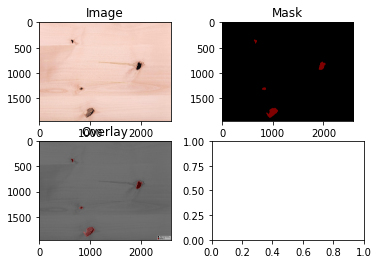

In [40]:
'''Visualizing an image with it's mask'''

image = Image.open("data/positive/1/img.png")
mask = Image.open("data/positive/1/label.png")
label_viz = Image.open("data/positive/1/label_viz.png")

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(image)
axs[0, 0].set_title('Image')
axs[0,1].imshow(mask)
axs[0, 1].set_title('Mask')
axs[1,0].imshow(label_viz)
axs[1, 0].set_title('Overlay')
plt.show()

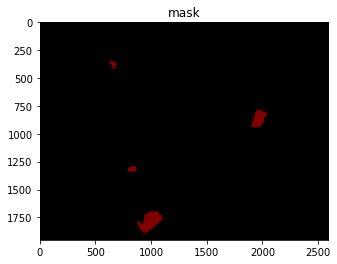

In [41]:
'''Visualizing only the mask'''
three = Image.open("data/positive/1/label.png")
plt.imshow(three)
plt.title("mask")
plt.show()

In [126]:
'''Class responsible for Data Loading
Phase represents train or val stage
stage represents first stage or second stage
first: classification
second: segmentation'''
class WoodDataset(Dataset):
    def __init__(self, df, data_folder, phase, stage='first'):
        self.df = df
        self.root = data_folder
        self.phase = phase
        self.transform = get_transforms(phase, stage)
        self.fnames = self.df.index.tolist()
        self.stage = stage

    def __getitem__(self, idx):
      image_path = self.df.iloc[idx]['image']
      img = io.imread(image_path)
      if self.stage == 'first':
        label = self.df.iloc[idx]['label']
        img = self.transform(img)
        return img,label
      else:
        mask_path = self.df.iloc[idx]['mask']
        mask = io.imread(mask_path)
        mask = rgb2gray(mask)
        augmented = self.transform(image=img, mask=mask)
        aug_img = augmented['image']
        aug_mask = augmented['mask']
        return aug_img, aug_mask

    def __len__(self):
      return len(self.fnames)


def get_transforms(phase='train', stage='first'):
  '''returns transformations for images for each stage/ phase'''
  if stage=='first':
    transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize((244, 324)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
     ])
    return transform
  else:
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [   Resize(128,128),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
                ToTensor()
            ]
        )
    else:
      list_transforms.extend(
          [
              Resize(128,128),
              Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
              ToTensor(),
          ]
      )
    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(data_folder, df, phase, stage='first', batch_size=BATCH_SIZE, num_workers=1):
    '''Returns dataloader for the model training'''

    train_df, val_df = train_test_split(df, test_size=0.2, random_state=69)
    df = train_df if phase == "train" else val_df
    image_dataset = WoodDataset(df, data_folder, phase, stage)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )

    return dataloader

In [18]:
'''calculates dice scores when Scores class for it'''
def dice_score(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

''' initialize a empty list when Scores is called, append the list with dice scores
for every batch, at the end of epoch calculates mean of the dice scores'''
class Scores:
    def __init__(self, phase, epoch):
        self.base_dice_scores = []

    def update(self, targets, outputs):
        probs = outputs
        dice= dice_score(probs, targets)
        self.base_dice_scores.append(dice)

    def get_metrics(self):
        dice = np.mean(self.base_dice_scores)         
        return dice

In [67]:
'''Function that trains the first model
First model is used for classification task:
Classify if image has a defect or not

taken from pytorch documentation and modified according to need'''
def train_model_first(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    result_dict = {
        "train_acc": train_acc_history,
        "train_loss": train_loss_history,
        "val_acc": val_acc_history,
        "val_loss": val_loss_history
    }

    return model, result_dict

def check_accuracy(loader, model):
  '''returns the predictions of the loader by the model
  also prints the accuracy'''
    num_correct = 0
    num_samples = 0
    model.eval()
    preds = []
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=DEVICE)
            y = y.to(device=DEVICE)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            preds = preds + predictions.cpu().numpy().tolist()
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()
    return preds

In [76]:
'''This cell contains the function and helper functions required
to train the second model:
That model is responsible to perform image segmentation'''
accumulation_steps = 4 // BATCH_SIZE

def forward(model, criterion, images, targets):
  images = images.to(DEVICE)
  masks = targets.to(DEVICE)
  outputs = model(images)
  loss = criterion(outputs, masks)
  return loss, outputs

def iterate(model, dataloaders, optimizer, epoch, phase):
  measure=Scores(phase, epoch)
  model.train(phase=="train")
  dataloader=dataloaders[phase]
  running_loss=0.0
  total_batches=len(dataloader)
  optimizer.zero_grad()
  for itr,batch in enumerate(dataloader):
    images,mask_target=batch
    loss, pred_mask=forward(model, criterion, images, mask_target)
    loss=loss/accumulation_steps
    if phase=='train':
      loss.backward()
      if (itr+1) % accumulation_steps ==0:
        optimizer.step()
        optimizer.zero_grad()
    running_loss+=loss.item()
    pred_mask=pred_mask.detach().cpu()
    measure.update(mask_target,pred_mask)
  epoch_loss=(running_loss*accumulation_steps)/total_batches
  dice=measure.get_metrics()
  torch.cuda.empty_cache()
  return epoch_loss, dice


def train_model_second(model, dataloaders, criterion, optimizer, num_epochs):
  since = time.time()

  val_dice_history = []
  train_dice_history = []

  val_loss_history = []
  train_loss_history = []

  best_model_wts = copy.deepcopy(model.state_dict())
  best_dice = 0.0
  best_loss = np.inf
  accumulation_steps = 4/BATCH_SIZE

  cudnn.benchmark= True


  for epoch in range (num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    epoch_loss,dice=iterate(model, dataloaders, optimizer, epoch, "train")
    train_dice_history.append(dice)
    train_loss_history.append(epoch_loss)

    print('Train Loss: {:.4f} Dice: {:.4f}'.format(epoch_loss, dice))

    with torch.no_grad():
      val_loss, dice=iterate(model, dataloaders, optimizer, epoch, "val")
      val_dice_history.append(dice)
      val_loss_history.append(val_loss)
      if val_loss < best_loss:
        best_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())

    print('Val Loss: {:.4f} Dice: {:.4f}'.format(val_loss, dice))
    
    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Dice: {:4f}'.format(best_dice))
  print('Best val Loss: {:4f}'.format(best_loss))

  # load best model weights
  model.load_state_dict(best_model_wts)

  result_dict = {
      "train_dice": train_dice_history,
      "train_loss": train_loss_history,
      "val_dice": val_dice_history,
      "val_loss": val_loss_history
  }

  return model, result_dict

In [198]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    """ Resnet101
    """
    model_ft = models.resnet101(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)

    return model_ft


feature_extract = False
# Initialize the model for this run
model_ft = initialize_model(2, feature_extract, use_pretrained=True)

In [199]:
model_ft = model_ft.to(DEVICE)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
feature_extract = True
# print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            # print("\t",name)
else:
    '''So I am updating the weights only for the last fc layer and layer 4'''
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True and ('fc' in name or 'layer4' in name):
        # if param.requires_grad == True and 'fc' in name:
            params_to_update.append(param)
            # print("\t",name)

# Observe that all parameters are being optimized
optimizer = optim.Adamax(params_to_update)

train_loader = provider("",df,"train", batch_size=BATCH_SIZE)
val_loader = provider("",df,"val", batch_size=BATCH_SIZE)

test_dataset_ft = WoodDataset(df, "", "val", "first")
test_loader_ft = DataLoader(
    test_dataset_ft,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    shuffle=False,   
)

dataloaders_dict_first = {"train": train_loader,
                    "val": val_loader}

criterion_ft = nn.CrossEntropyLoss()
# Train and evaluate
model_ft, hist = train_model_first(model_ft, dataloaders_dict_first, criterion_ft, optimizer,20)

Epoch 0/19
----------
train Loss: 1.0531 Acc: 0.6000
val Loss: 6.5414 Acc: 0.5000

Epoch 1/19
----------
train Loss: 0.8381 Acc: 0.8000
val Loss: 1.4374 Acc: 0.5000

Epoch 2/19
----------
train Loss: 0.7603 Acc: 0.8000
val Loss: 5.4724 Acc: 0.5000

Epoch 3/19
----------
train Loss: 0.5350 Acc: 0.8000
val Loss: 0.6762 Acc: 0.5000

Epoch 4/19
----------
train Loss: 0.5740 Acc: 0.8000
val Loss: 0.6316 Acc: 0.5000

Epoch 5/19
----------
train Loss: 0.6035 Acc: 0.8000
val Loss: 0.8974 Acc: 0.5000

Epoch 6/19
----------
train Loss: 0.5207 Acc: 0.8000
val Loss: 0.8778 Acc: 0.5000

Epoch 7/19
----------
train Loss: 0.4242 Acc: 0.8000
val Loss: 0.6593 Acc: 0.5000

Epoch 8/19
----------
train Loss: 0.4405 Acc: 0.8000
val Loss: 1.2939 Acc: 0.5000

Epoch 9/19
----------
train Loss: 0.5385 Acc: 0.8000
val Loss: 8.5714 Acc: 0.0000

Epoch 10/19
----------
train Loss: 0.3786 Acc: 0.8000
val Loss: 1.5205 Acc: 0.5000

Epoch 11/19
----------
train Loss: 0.4206 Acc: 0.8000
val Loss: 1.5903 Acc: 0.5000

Ep

In [200]:
hist['train_acc'] = [i.cpu().numpy().tolist() for i in hist['train_acc']]
hist['val_acc'] = [i.cpu().numpy().tolist() for i in hist['val_acc']]

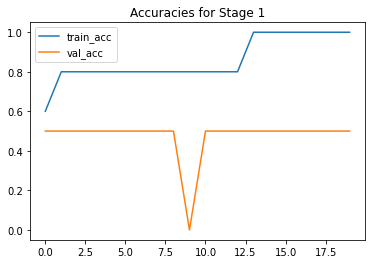

In [201]:
plt.plot(hist['train_acc'], label='train_acc')
plt.plot(hist['val_acc'], label='val_acc')
plt.title("Accuracies for Stage 1")
plt.legend()
plt.show()

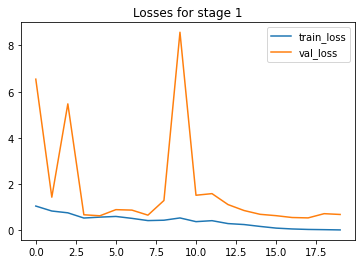

In [202]:
plt.plot(hist['train_loss'], label="train_loss")
plt.plot(hist['val_loss'], label='val_loss')
plt.title('Losses for stage 1')
plt.legend()
plt.show()

In [203]:
preds = check_accuracy(test_loader_ft, model_ft)

Got 6 / 7 with accuracy 85.71


In [204]:
df_one = df.copy()
df_one['preds'] = preds
df_one.to_csv("classification_result.csv")

In [205]:
from sklearn.metrics import confusion_matrix
y_true = df_one['label']
y_preds = df_one['preds']

confusion_matrix(y_true, y_preds)

array([[1, 1],
       [0, 5]])

In [206]:
train_loader = provider("",df_second,"train", stage='second', batch_size=BATCH_SIZE)
val_loader = provider("",df_second,"val", stage='second', batch_size=BATCH_SIZE)

dataloaders_dict_second = {"train": train_loader,
                    "val": val_loader}

model = smp.Unet("resnet50", encoder_weights="imagenet", classes=1, activation=None)
model.to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer=optim.Adam(model.parameters(),lr=5e-4)
model, hist = train_model_second(model, dataloaders_dict_second, criterion, optimizer, 300)

Epoch 0/299
----------
Train Loss: 0.6444 Dice: 0.0018
Val Loss: 0.6613 Dice: 0.0005

Epoch 1/299
----------
Train Loss: 0.6191 Dice: 0.0021
Val Loss: 0.6050 Dice: 0.0005

Epoch 2/299
----------
Train Loss: 0.5874 Dice: 0.0028
Val Loss: 0.5213 Dice: 0.0002

Epoch 3/299
----------
Train Loss: 0.5610 Dice: 0.0027
Val Loss: 0.4869 Dice: 0.0001

Epoch 4/299
----------
Train Loss: 0.5308 Dice: 0.0039
Val Loss: 0.5206 Dice: 0.0005

Epoch 5/299
----------
Train Loss: 0.5002 Dice: 0.0041
Val Loss: 0.5074 Dice: 0.0009

Epoch 6/299
----------
Train Loss: 0.4740 Dice: 0.0070
Val Loss: 0.4060 Dice: 0.0000

Epoch 7/299
----------
Train Loss: 0.4508 Dice: 0.0074
Val Loss: 0.3508 Dice: 0.0000

Epoch 8/299
----------
Train Loss: 0.4285 Dice: 0.0082
Val Loss: 0.3205 Dice: 0.0004

Epoch 9/299
----------
Train Loss: 0.3999 Dice: 0.0155
Val Loss: 0.3021 Dice: 0.0006

Epoch 10/299
----------
Train Loss: 0.3773 Dice: 0.0136
Val Loss: 0.3232 Dice: 0.0010

Epoch 11/299
----------
Train Loss: 0.3582 Dice: 0.01

In [156]:
hist['train_dice'] = [i.tolist() for i in hist['train_dice']]
hist['val_dice'] = [i.tolist() for i in hist['val_dice']]

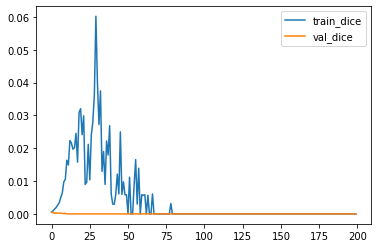

In [157]:
plt.plot(hist['train_dice'], label='train_dice')
plt.plot(hist['val_dice'], label='val_dice')
plt.legend()
plt.show()

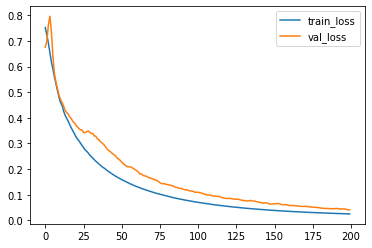

In [158]:
plt.plot(hist['train_loss'], label="train_loss")
plt.plot(hist['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [208]:
df_two = df_one[(df_one['label']==df_one['preds']) & (df_one['preds'] == 1)]

In [216]:
test_dataset = WoodDataset(df_two, "", "val", "second")
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    shuffle=False,   
)

In [217]:
df_two

,image,mask,label,preds
2,data/positive/8/img.png,data/positive/8/label.png,1,1
3,data/positive/2/img.png,data/positive/2/label.png,1,1
4,data/positive/7/img.png,data/positive/7/label.png,1,1
5,data/positive/1/img.png,data/positive/1/label.png,1,1
6,data/positive/4/img.png,data/positive/4/label.png,1,1


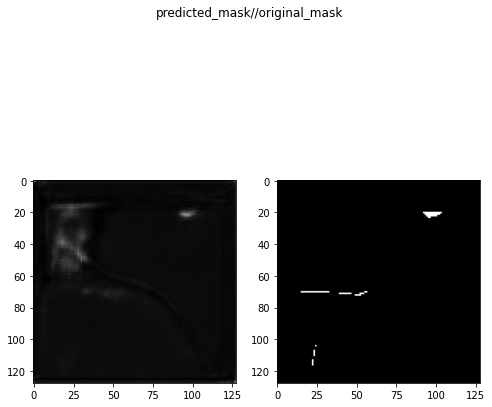

In [223]:
test_iter = iter(test_loader)
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(8,8))
fig.suptitle('predicted_mask//original_mask')
batch = test_iter.next()
images,mask_target = batch
batch_preds = torch.sigmoid(model(images.to(DEVICE)))
batch_preds = batch_preds.detach().cpu().numpy()
ax1.imshow(np.squeeze(batch_preds),cmap='gray')
ax2.imshow(np.squeeze(mask_target),cmap='gray')
plt.show()

# how you would improve the model in the near future

I would love to add some more data! and the other plan I had was to use a single model which does both jobs classify the image and then segemnt it.

I was reading a paper on this before solving the problem but that implementation could not use the pre-trained models and needed a large amount of data. (I lost the paper sorry otherwise wouldve linked it here)

The other thing I would like to do is Test-Time Augmentation which augments the images during the test time and the final result is the average of all results

# how you would transfer learnings to other types of surfaces

Let's say we want to identify defects in steel.
Once I have a fuilly trained model on wood data, transferring it for another problem is not that hard. Make sure to include BatchNorm layers and then freeze majority of the model and train only the final few layers on the steel data.

This will work as the first few layers of the model are responsible to capture the low-level feratures like edges. Where as the final layers detect the high level features like defects.

If the wood model is trained on a significantly large sized dataset, it will be an expert in identifying low-level features and will only require a fine-tune for other detection problems.

In [207]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')